# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [39]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

from scipy.stats import linregress
from citipy import citipy
from pprint import pprint

from api_keys import weather_api_key
from api_keys import g_key

# Set output file path
output_file = "../output_files/cities_weather.csv"

# Set range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [40]:
# Creat empty lists for lat_lgn and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low = -90.000, high = 90.000, size = 1500)
lngs = np.random.uniform(low = -180.000, high = 180.000, size = 1500)
lat_lngs = zip(lats, lngs)

# Find the closest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
# If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(f"There's %s cities to poll for weather." % len(cities))

There's 603 cities to poll for weather.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [41]:
# Setup Query URL
base_url = "http://api.openweathermap.org/data/2.5/weather?appid="
api_key = weather_api_key
units = "imperial"
query_url = f"{base_url}{api_key}&units={units}&q="

In [42]:
# Create dictionary to store data from API calls
city_weather_data = {"City": [],
                     "Lat": [],
                     "Lng": [],
                     "Max Temp": [],
                     "Humidity": [],
                     "Cloudiness": [],
                     "Wind Speed": [],
                     "Country": [],
                     "Date": []}

# Loop thru the API call data to add the data retrieved into the dictionary
for i, city in enumerate(cities):
    city = requests.get(query_url + cities[i].replace(" ","&")).json()

    try:
        print(f"Processing city " + str(i) + ": " + city["name"])

        city_weather_data["City"].append(city["name"])
        city_weather_data["Lat"].append(city["coord"]["lat"])
        city_weather_data["Lng"].append(city["coord"]["lon"])
        city_weather_data["Max Temp"].append(city["main"]["temp_max"])
        city_weather_data["Humidity"].append(city["main"]["humidity"])
        city_weather_data["Cloudiness"].append(city["clouds"]["all"])
        city_weather_data["Wind Speed"].append(city["wind"]["speed"])
        city_weather_data["Country"].append(city["sys"]["country"])
        city_weather_data["Date"].append(city["dt"])

    except:
        print(f"Data retrieve failure. Skipping city instance...")
        pass
print("Data retrieval is completed.")

Processing city 0: Ushuaia
Processing city 1: Busselton
Processing city 2: Arraial
Processing city 3: Port
Processing city 4: Namatanai
Processing city 5: Santa
Data retrieve failure. Skipping city instance...
Data retrieve failure. Skipping city instance...
Processing city 8: Athabasca
Processing city 9: Rikitea
Processing city 10: Maragogi
Processing city 11: Palmer
Processing city 12: Kapaa
Processing city 13: Yellowknife
Processing city 14: Artyom
Data retrieve failure. Skipping city instance...
Processing city 16: Mombetsu
Processing city 17: Saint-Augustin
Processing city 18: Saint-Philippe
Processing city 19: Sitka
Processing city 20: Hermanus
Processing city 21: Shimoda
Processing city 22: Punta
Processing city 23: Khatanga
Processing city 24: Qaanaaq
Processing city 25: Atuona
Processing city 26: Narsaq
Processing city 27: Meulaboh
Processing city 28: Basco
Processing city 29: Hithadhoo
Processing city 30: George Town
Data retrieve failure. Skipping city instance...
Processing

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [43]:
# Export the city data into CSV
city_weather_df = pd.DataFrame(city_weather_data)
city_weather_df.to_csv(output_file, index = False)

# Display DataFrame
print(city_weather_df.head())

# Count the number of cities with data that were successfully pulled from API call
city_retrieved = city_weather_df["City"].count()
print(f"There's %s cities data retrieved out of {len(cities)} cities." % city_retrieved)

# Calculate successful rate
success_rate = round((city_retrieved / len(cities) * 100),2)
print(f"Success rate is: %s" % success_rate  + "%.")

        City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
0    Ushuaia -54.8000  -68.3000     38.86        60          20        5.75   
1  Busselton -33.6500  115.3333     49.05        83           5        9.37   
2    Arraial -22.8362  -46.6460     67.41        47          92        0.36   
3       Port  -7.0349   29.7638     82.54        33          63        3.60   
4  Namatanai  -3.6667  152.4333     79.59        81          91        8.10   

  Country        Date  
0      AR  1631364130  
1      AU  1631364131  
2      BR  1631364131  
3      CD  1631364132  
4      PG  1631364133  
There's 546 cities data retrieved out of 603 cities.
Success rate is: 90.55%.


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [44]:
# Test to make sure no city has humdity over 100%
test_stats = city_weather_df["Humidity"].describe()
print(test_stats)
print(f"Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.")

count    546.000000
mean      67.840659
std       21.716317
min        7.000000
25%       55.000000
50%       72.000000
75%       86.000000
max      100.000000
Name: Humidity, dtype: float64
Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.


In [45]:
#  Get the indices of cities that have humidity over 100%.

In [46]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [47]:
# Creates variables for relevant table columns
lat = city_weather_df["Lat"]
max_temp = city_weather_df["Max Temp"]
humidity = city_weather_df["Humidity"]
cloudiness = city_weather_df["Cloudiness"]
wind_speed = city_weather_df["Wind Speed"]

## Latitude vs. Temperature Plot

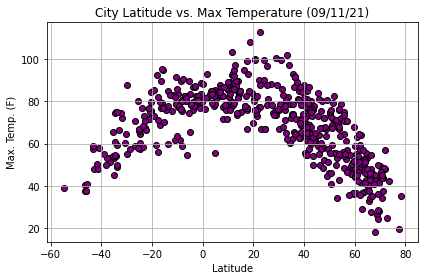

In [48]:
# Plotting data into graph
plt.scatter(lat, max_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max. Temp. (F)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Temp.png")

## Latitude vs. Humidity Plot

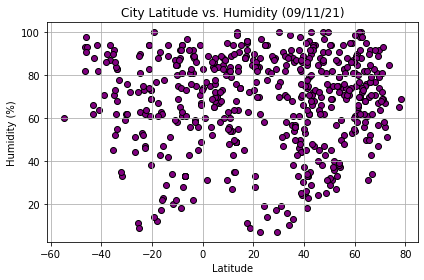

In [49]:
# Plotting data into graph
plt.scatter(lat, humidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Humid.png")

## Latitude vs. Cloudiness Plot

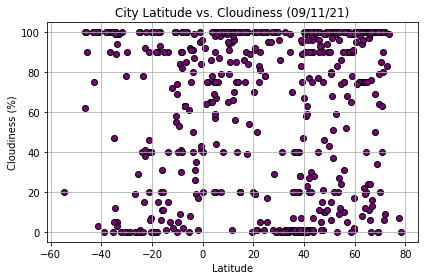

In [50]:
# Plotting data into graph
plt.scatter(lat, cloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Cloud.png")

## Latitude vs. Wind Speed Plot

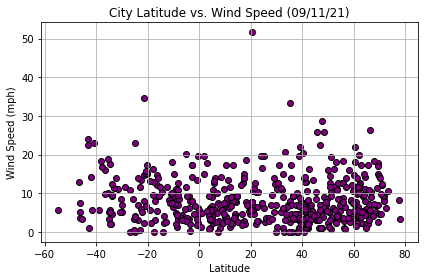

In [51]:
# Plotting data into graph
plt.scatter(lat, wind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Wind.png")

## Linear Regression

In [117]:
# Define plotting function
def plot_linear_regression(xdata, ydata, ylbl, lblpos, title, savefig):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    plt.scatter(xdata, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.plot(xdata,regress_values, "orange")
    plt.annotate(line_eq, lblpos, fontsize = 15, color = "orange")
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(ylbl)
    plt.tight_layout()
    plt.savefig("../output_files/savefig")

In [52]:
# Create Northern Hemisphere DataFrames
northern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] >= 0.0]
northern_hemisphere.reset_index(inplace = True)

# Create Southern Hemisphere DataFrames
southern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] < 0.0]
southern_hemisphere.reset_index(inplace = True)

print(northern_hemisphere.head())
print(southern_hemisphere.head())

   index         City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      5        Santa  17.4860  120.4348     77.04        96         100   
1      6    Athabasca  54.7169 -113.2854     54.43        74          86   
2      9       Palmer  42.1584  -72.3287     62.73        79          20   
3     10        Kapaa  22.0752 -159.3190     77.32        70          75   
4     11  Yellowknife  62.4560 -114.3525     41.52       100          75   

   Wind Speed Country        Date  
0       13.82      PH  1631364134  
1        5.48      CA  1631364136  
2        1.01      US  1631364139  
3       10.36      US  1631364045  
4       11.50      CA  1631363873  
   index       City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      0    Ushuaia -54.8000  -68.3000     38.86        60          20   
1      1  Busselton -33.6500  115.3333     49.05        83           5   
2      2    Arraial -22.8362  -46.6460     67.41        47          92   
3      3       Port  -7.0349   

In [53]:
# Create variables for relevant table columns
nlat = northern_hemisphere["Lat"]
nmax_temp = northern_hemisphere["Max Temp"]
nhumidity = northern_hemisphere["Humidity"]
ncloudiness = northern_hemisphere["Cloudiness"]
nwind_speed = northern_hemisphere["Wind Speed"]

slat = southern_hemisphere["Lat"]
smax_temp = southern_hemisphere["Max Temp"]
shumidity = southern_hemisphere["Humidity"]
scloudiness = southern_hemisphere["Cloudiness"]
swind_speed = southern_hemisphere["Wind Speed"]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.7917219446830033


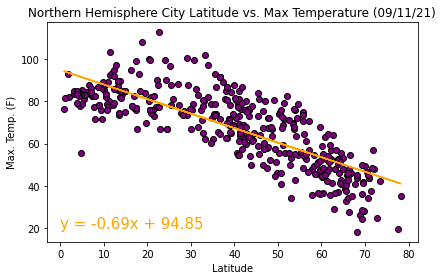

In [119]:
# Create Scatter Plot for Northern Hemisphere - Max Temp vs. Latitude Linear Regression
ylbl = "Max. Temp. (F)"
lblpos = (0, 20)
savefig = "NLat_Temp.png"
title = "Northern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nmax_temp, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7706946157083209


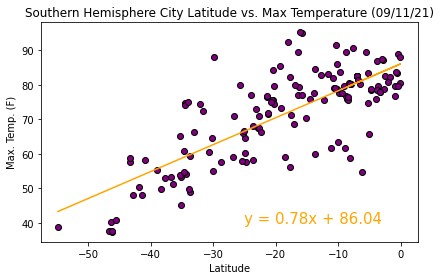

In [120]:
# Create Scatter Plot for Southern Hemisphere - Max Temp vs. Latitude Linear Regression
ylbl = "Max. Temp. (F)"
lblpos = (-25, 40)
savefig = "SLat_Temp.png"
title = "Southern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(slat, smax_temp, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.013350285234815958


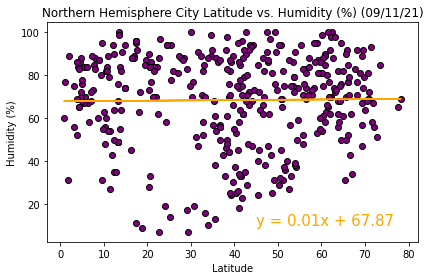

In [121]:
# Create Scatter Plot for Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (45, 10)
savefig = "NLat_Humid"
title = "Northern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nhumidity, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: -0.14036871739565077


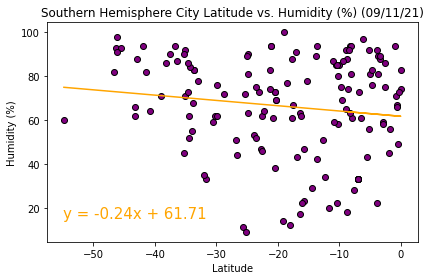

In [123]:
# Create Scatter Plot for Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (-55, 15)
savefig = "SLat_Humid"
title = "Southern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, shumidity, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: -0.07639346430585561


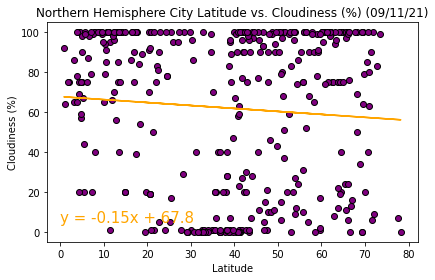

In [124]:
# Create Scatter Plot for Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (0, 5)
savefig = "NLat_Cloud"
title = "Northern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, ncloudiness, ylbl, lblpos, title, savefig)

# Save graph as PNG
plt.savefig("../output_files/NLat_Cloud.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: -0.06539336774856294


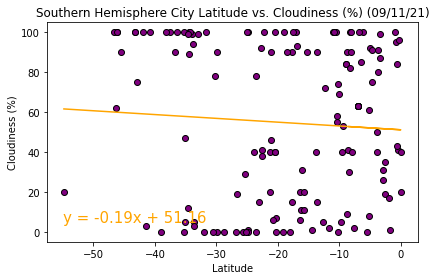

In [125]:
# Create Scatter Plot for Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (-55, 5)
savefig = "SLat_Cloud"
title = "Southern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, scloudiness, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.06487812668451926


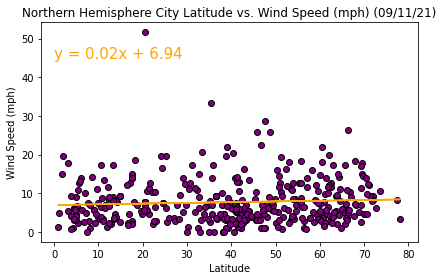

In [115]:
# Create Scatter Plot for Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (0, 45)
savefig = "NLat_Wind"
title = "Northern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nwind_speed, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.16155402314400696


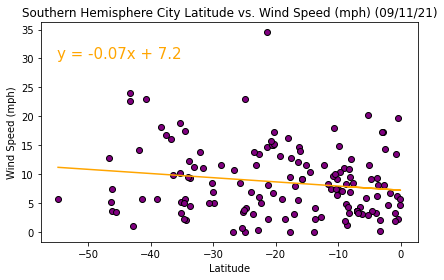

In [116]:
# Create Scatter Plot for Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (-55, 30)
title = "Southern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(slat, swind_speed, ylbl, lblpos, title)

# Save graph as PNG
plt.savefig("../output_files/SLat_Wind.png")